In [80]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader

In [81]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [82]:
print(f"Train dataset has {len(train_dataset)} images")
print(f"Test dataset has {len(test_dataset)} images")

Train dataset has 73257 images
Test dataset has 26032 images


In [83]:
import matplotlib.pyplot as plt

def show_images(images, labels):
    plt.figure(figsize=(8, 8))
    for i in range(len(images)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].permute(1, 2, 0) / 2 + 0.5)  # Unnormalize for display
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

Image shape: torch.Size([3, 32, 32])


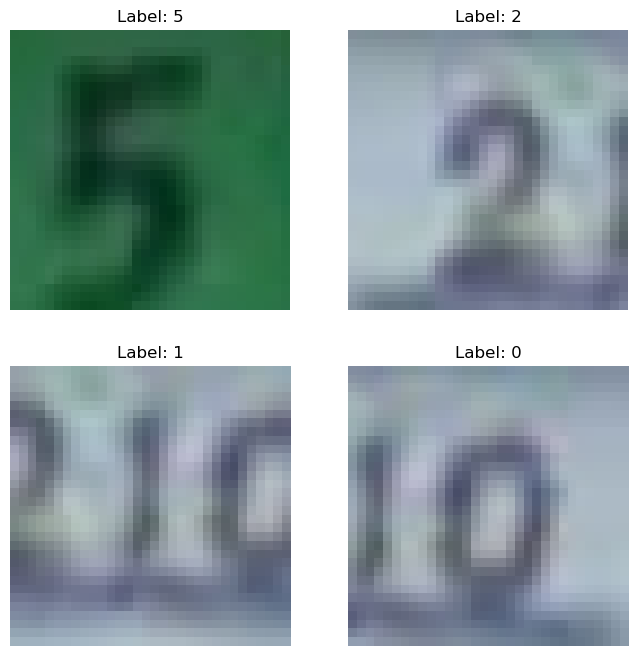

In [84]:
images, labels = next(iter(test_loader))
print(f"Image shape: {images[0].shape}")
show_images(images, labels)

In [85]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [86]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [87]:
epochs = 2

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad() # Clear previous gradients
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/2], Loss: 1.1645
Epoch [2/2], Loss: 0.4624


In [88]:
net.eval()
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

print(f"Accuracy: {round((100 * correct / total), 3)}%")

Accuracy: 84.231%


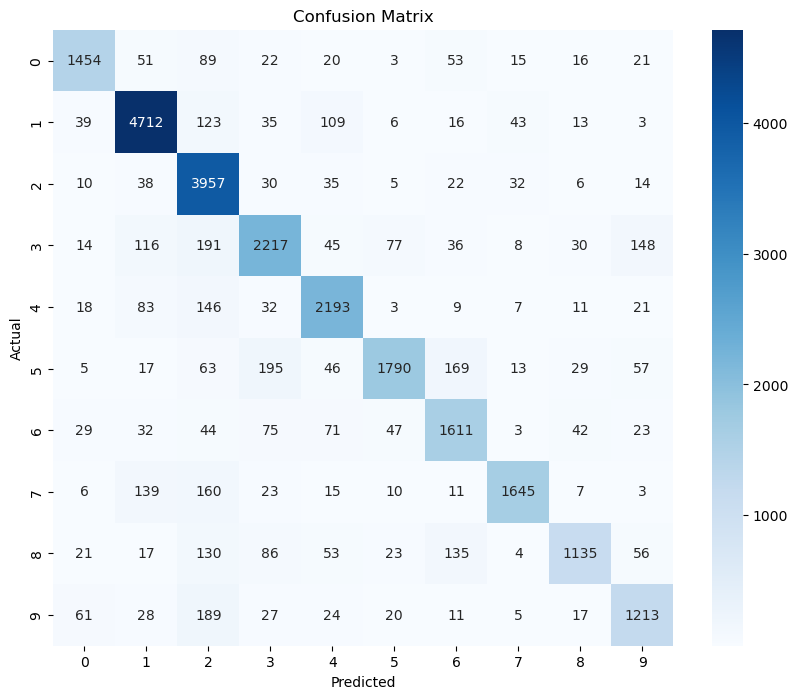

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=np.arange(10), 
            yticklabels=np.arange(10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [90]:
torch.save(net, 'models/svhn.pth')